In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!find /content/drive/MyDrive -name 'CS4243'
!find /content/drive/MyDrive -name 'output-train-by-char.zip'
!find /content/drive/MyDrive -name 'output-test.zip'

Mounted at /content/drive
/content/drive/MyDrive/NUS/AY24 25/CS4243
/content/drive/MyDrive/NUS/AY24 25/CS4243/output-train-by-char.zip
/content/drive/MyDrive/NUS/AY24 25/output-train-by-char.zip
/content/drive/MyDrive/NUS/AY24 25/CS4243/output-test.zip


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/NUS/AY24 25/CS4243/output-train-by-char.zip'
extract_path = './dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #print(zip_ref.namelist())
    zip_ref.extractall(extract_path)


In [ ]:
# modify and load pretrained model

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception v3 default input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset = datasets.ImageFolder(root='./dataset/output-train-by-char', transform=transform)
#print(dataset.class_to_idx)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
# model setup
import timm
import torch
print("CUDA Avail:", torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NUM_FINETUNE_CLASSES = 36
model = timm.create_model('inception_v3', pretrained=True, num_classes=NUM_FINETUNE_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


CUDA Avail: True


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

In [ ]:
# fine tuning
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%")



Epoch 1/10, Train Loss: 0.8561, Train Acc: 75.25%, Val Loss: 0.4383, Val Acc: 85.80%
Epoch 2/10, Train Loss: 0.3367, Train Acc: 88.95%, Val Loss: 0.3645, Val Acc: 88.02%
Epoch 3/10, Train Loss: 0.2477, Train Acc: 91.35%, Val Loss: 0.3135, Val Acc: 90.03%
Epoch 4/10, Train Loss: 0.1982, Train Acc: 92.80%, Val Loss: 0.3026, Val Acc: 90.40%
Epoch 5/10, Train Loss: 0.1660, Train Acc: 93.78%, Val Loss: 0.3364, Val Acc: 90.02%
Epoch 6/10, Train Loss: 0.1504, Train Acc: 94.42%, Val Loss: 0.3676, Val Acc: 89.76%
Epoch 7/10, Train Loss: 0.1271, Train Acc: 95.23%, Val Loss: 0.3185, Val Acc: 91.02%
Epoch 8/10, Train Loss: 0.1177, Train Acc: 95.69%, Val Loss: 0.3233, Val Acc: 90.95%
Epoch 9/10, Train Loss: 0.0993, Train Acc: 96.31%, Val Loss: 0.3569, Val Acc: 90.42%
Epoch 10/10, Train Loss: 0.0964, Train Acc: 96.44%, Val Loss: 0.3908, Val Acc: 89.35%


In [ ]:
torch.save(model.state_dict(), 'model2.pth')
from google.colab import files
files.download('model2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

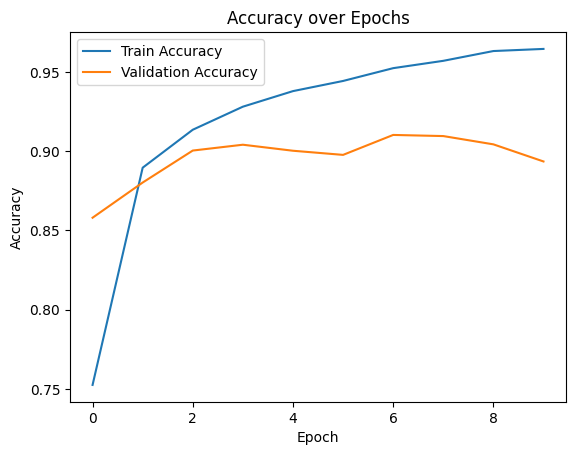

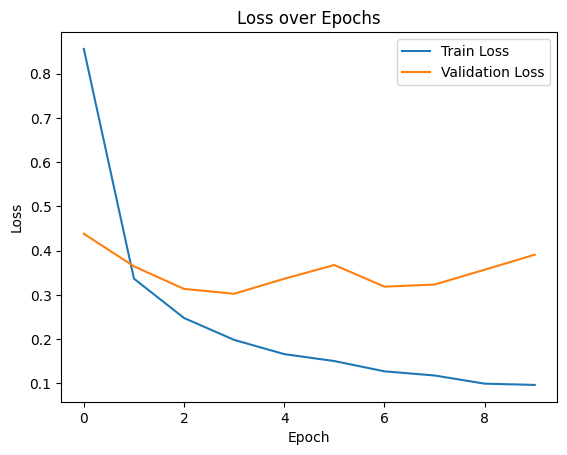

In [ ]:
# plot learning curves
import matplotlib.pyplot as plt

plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

TEST

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
!find /content/drive/MyDrive -name 'output-test.zip'
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n!find /content/drive/MyDrive -name 'output-test.zip'\n"

In [ ]:
zip_path = '/content/drive/MyDrive/NUS/AY24 25/CS4243/output-test.zip'
extract_path = './dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

transform = transforms.Compose([
    transforms.Resize((299, 299)),  # match Inception v3 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

test_dataset = datasets.ImageFolder(root='./dataset/output-test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

model.eval()  # just to be safe
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# overall metrics
accuracy = accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
recall = recall_score(all_test_labels, all_test_preds, average='macro', zero_division=0)

print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Macro Precision: {precision:.4f}")
print(f"Test Macro Recall: {recall:.4f}")

# metrics for each class
class_names = list(test_dataset.class_to_idx.keys())
report = classification_report(all_test_labels, all_test_preds, target_names=class_names, zero_division=0)
print("\nDetailed Test Classification Report:")
print(report)

# save report
with open("test_classification_report.txt", "w") as f:
    f.write(report)

files.download('test_classification_report.txt')



Test Accuracy: 86.76%
Test Macro Precision: 0.8771
Test Macro Recall: 0.8694

Detailed Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       258
           1       0.62      0.69      0.66       234
           2       0.96      0.69      0.81       249
           3       0.98      0.92      0.95       227
           4       0.98      0.92      0.95       235
           5       0.90      0.89      0.89       238
           6       0.96      0.90      0.93       224
           7       0.91      0.88      0.89       233
           8       0.92      0.93      0.93       253
           9       0.94      0.84      0.89       268
           a       0.95      0.82      0.88       268
           b       0.93      0.94      0.94       255
           c       0.97      0.87      0.92       256
           d       0.87      0.91      0.89       270
           e       0.95      0.91      0.93       237
           f       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CITATION:

@article{DBLP:journals/corr/SzegedyVISW15,
  author    = {Christian Szegedy and
               Vincent Vanhoucke and
               Sergey Ioffe and
               Jonathon Shlens and
               Zbigniew Wojna},
  title     = {Rethinking the Inception Architecture for Computer Vision},
  journal   = {CoRR},
  volume    = {abs/1512.00567},
  year      = {2015},
  url       = {http://arxiv.org/abs/1512.00567},
  archivePrefix = {arXiv},
  eprint    = {1512.00567},
  timestamp = {Mon, 13 Aug 2018 16:49:07 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/SzegedyVISW15.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}

LINK: https://huggingface.co/docs/timm/en/models/inception-v3

EMNIST (Extended MNIST) — for handwritten letters (balanced or letters split)
https://www.nist.gov/itl/products-and-services/emnist-dataset

https://github.com/ruchitapaithankar15/Optical-character-recognition-using-Inception-V3-and-VGG16


partial fine tuning

In [ ]:

model = timm.create_model('inception_v3', pretrained=True)

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze last two inception blocks
for name, child in model.named_children():
    if name in ['Mixed_7b', 'Mixed_7c']:
        for param in child.parameters():
            param.requires_grad = True

# add classification head
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 36)  # 36 output classes (0–9, a–z)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%")

Epoch 1/10, Train Loss: 1.6364, Train Acc: 53.33%, Val Loss: 0.7409, Val Acc: 77.53%
Epoch 2/10, Train Loss: 0.6890, Train Acc: 79.23%, Val Loss: 0.5683, Val Acc: 81.73%
Epoch 3/10, Train Loss: 0.4564, Train Acc: 85.54%, Val Loss: 0.5238, Val Acc: 83.66%
Epoch 4/10, Train Loss: 0.3313, Train Acc: 88.96%, Val Loss: 0.5077, Val Acc: 84.04%
Epoch 5/10, Train Loss: 0.2410, Train Acc: 91.74%, Val Loss: 0.5389, Val Acc: 83.51%
Epoch 6/10, Train Loss: 0.1865, Train Acc: 93.58%, Val Loss: 0.5511, Val Acc: 84.09%
Epoch 7/10, Train Loss: 0.1550, Train Acc: 94.67%, Val Loss: 0.5654, Val Acc: 84.50%
Epoch 8/10, Train Loss: 0.1259, Train Acc: 95.67%, Val Loss: 0.6139, Val Acc: 83.96%
Epoch 9/10, Train Loss: 0.1129, Train Acc: 96.30%, Val Loss: 0.6375, Val Acc: 84.30%
Epoch 10/10, Train Loss: 0.0937, Train Acc: 96.87%, Val Loss: 0.6463, Val Acc: 83.95%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

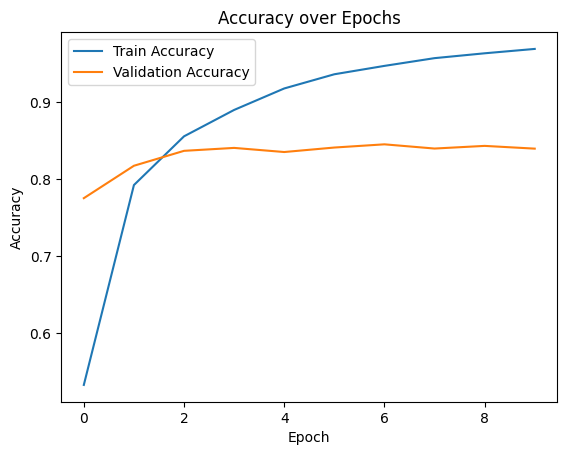

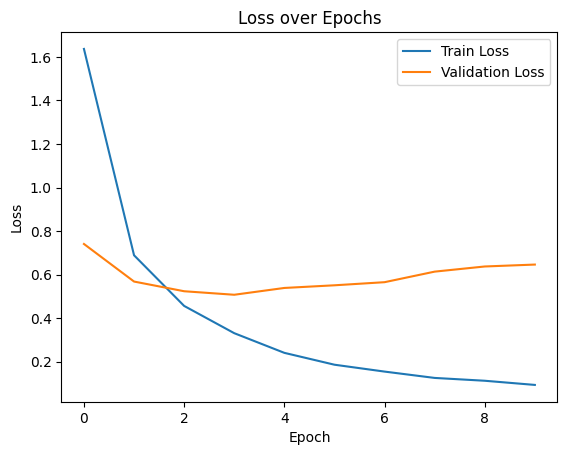

<Figure size 640x480 with 0 Axes>

In [ ]:
torch.save(model.state_dict(), 'model3.pth')
from google.colab import files
files.download('model3.pth')

import matplotlib.pyplot as plt

plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()
plt.savefig("I3_accuracy_curve.png")


plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()
plt.savefig("I3_loss_curve.png")

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

model.eval()  # just to be safe
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# overall metrics
accuracy = accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
recall = recall_score(all_test_labels, all_test_preds, average='macro', zero_division=0)

print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Macro Precision: {precision:.4f}")
print(f"Test Macro Recall: {recall:.4f}")

# metrics for each class
class_names = list(test_dataset.class_to_idx.keys())
report = classification_report(all_test_labels, all_test_preds, target_names=class_names, zero_division=0)
print("\nDetailed Test Classification Report:")
print(report)

with open("test_classification_report.txt", "w") as f:
    f.write(report)

files.download('test_classification_report.txt')


Test Accuracy: 81.69%
Test Macro Precision: 0.8230
Test Macro Recall: 0.8199

Detailed Test Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.69      0.59       258
           1       0.55      0.66      0.60       234
           2       0.87      0.88      0.87       249
           3       0.91      0.90      0.90       227
           4       0.87      0.88      0.88       235
           5       0.86      0.82      0.84       238
           6       0.92      0.90      0.91       224
           7       0.76      0.93      0.84       233
           8       0.92      0.82      0.87       253
           9       0.89      0.75      0.81       268
           a       0.88      0.76      0.81       268
           b       0.85      0.87      0.86       255
           c       0.91      0.85      0.88       256
           d       0.93      0.85      0.89       270
           e       0.91      0.90      0.91       237
           f       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

performance without any tuning

In [ ]:
import timm
import torch ##
print("CUDA Avail:", torch.cuda.is_available())
import torch.nn as nn

NUM_FINETUNE_CLASSES = 36 #a-z,0-9
model = timm.create_model('inception_v3', pretrained=True, num_classes=NUM_FINETUNE_CLASSES)
#model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


CUDA Avail: True


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# overall metrics
accuracy = accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
recall = recall_score(all_test_labels, all_test_preds, average='macro', zero_division=0)

print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Macro Precision: {precision:.4f}")
print(f"Test Macro Recall: {recall:.4f}")

# metrics for each class
class_names = list(test_dataset.class_to_idx.keys())
report = classification_report(all_test_labels, all_test_preds, target_names=class_names, zero_division=0)
print("\nDetailed Test Classification Report:")
print(report)


Test Accuracy: 2.07%
Test Macro Precision: 0.0243
Test Macro Recall: 0.0202

Detailed Test Classification Report:
              precision    recall  f1-score   support

           0       0.01      0.02      0.01       258
           1       0.05      0.00      0.01       234
           2       0.00      0.00      0.00       249
           3       0.01      0.00      0.01       227
           4       0.00      0.00      0.00       235
           5       0.00      0.00      0.00       238
           6       0.00      0.00      0.00       224
           7       0.03      0.00      0.01       233
           8       0.01      0.06      0.02       253
           9       0.01      0.01      0.01       268
           a       0.00      0.00      0.00       268
           b       0.00      0.00      0.00       255
           c       0.00      0.00      0.00       256
           d       0.00      0.00      0.00       270
           e       0.00      0.00      0.00       237
           f       0